In [1]:
import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.lines as lines

In [2]:
data = pd.read_csv('dataset_europe.csv')
data.head()

id                                                url location  \
0  190275853.0  https://inaturalist-open-data.s3.amazonaws.com...   europe   
1  190276069.0  https://inaturalist-open-data.s3.amazonaws.com...   europe   
2  190276115.0  https://inaturalist-open-data.s3.amazonaws.com...   europe   
3  190276244.0  https://inaturalist-open-data.s3.amazonaws.com...   europe   
4  181777730.0  https://inaturalist-open-data.s3.amazonaws.com...   europe   

    latitude  longitude  wolves                         detections  
0  44.798333  34.240636       1                   1080 716 966 816  
1  44.798333  34.240636       1                    827 895 926 959  
2  44.798333  34.240636       1                    950 780 985 845  
3  44.798333  34.240636       2  1321 930 1245 987 837 918 901 976  
4  51.021834  12.555087       1                    321 612 411 706

In [3]:
data['type'] = data['wolves'].apply(lambda x: 'Alone' if x==1 else 'Couple' if x==2 else 'Group')
data.head()

id                                                url location  \
0  190275853.0  https://inaturalist-open-data.s3.amazonaws.com...   europe   
1  190276069.0  https://inaturalist-open-data.s3.amazonaws.com...   europe   
2  190276115.0  https://inaturalist-open-data.s3.amazonaws.com...   europe   
3  190276244.0  https://inaturalist-open-data.s3.amazonaws.com...   europe   
4  181777730.0  https://inaturalist-open-data.s3.amazonaws.com...   europe   

    latitude  longitude  wolves                         detections    type  
0  44.798333  34.240636       1                   1080 716 966 816   Alone  
1  44.798333  34.240636       1                    827 895 926 959   Alone  
2  44.798333  34.240636       1                    950 780 985 845   Alone  
3  44.798333  34.240636       2  1321 930 1245 987 837 918 901 976  Couple  
4  51.021834  12.555087       1                    321 612 411 706   Alone

In [4]:
data["wolves"] = pd.to_numeric(data["wolves"])
data.dtypes

id            float64
url            object
location       object
latitude      float64
longitude     float64
wolves          int64
detections     object
type           object
dtype: object

In [5]:
data['long'] = data['longitude'].round(decimals = 0)
data['lat'] = data['latitude'].round(decimals = 0)
wolves = data.groupby(by=['long','lat'])['wolves'].max().to_frame()
wolves.columns = ['wolves']
total = data.groupby(by=['long','lat'])['wolves'].count().to_frame()
total.columns = ['images']
graph = wolves.merge(total, left_on=['long','lat'], right_on=['long','lat'])
graph['Wolves observed'] = graph['wolves'].apply(lambda x: 'Alone' if x==1 else 'Couple' if x==2 else 'Group')
graph.reset_index(inplace=True)
graph.describe()

long        lat     wolves     images
count  37.000000  37.000000  37.000000  37.000000
mean   15.486486  47.216216   1.432432   4.324324
std    13.483780   5.845868   0.958603   5.196441
min    -9.000000  39.000000   1.000000   1.000000
25%     8.000000  43.000000   1.000000   2.000000
50%    14.000000  45.000000   1.000000   3.000000
75%    24.000000  51.000000   2.000000   4.000000
max    50.000000  64.000000   5.000000  30.000000

In [6]:
fig = px.scatter_geo(graph, lat='lat', lon='long', color='Wolves observed', size='images')#, color_continuous_scale='aggrnyl')
#style https://plotly.com/python/mapbox-layers/
#https://plotly.com/python-api-reference/generated/plotly.express.density_mapbox
fig.update_layout(legend_font_size=20)
fig.update_geos(fitbounds="locations")
fig.update_geos(projection_type="natural earth", showcountries=True)
fig.show()

In [7]:
columns = ['region', 'animal', 'images', 'detections', 'wolf', 'wolf_d', 'dog', 'dog_d']
data = pd.DataFrame(columns = columns)
for region, r in zip(['europe', 'world'], ['Europe', 'Outside Europe']):
    for animal, a in zip(['wolf', 'dog'], ['','_dog']):
        info = pd.read_csv('dataset'+a+'_'+region+'.csv')        
        if animal == 'wolf':
            info_row = [[r, animal, info.shape[0], info['wolves'].sum(), info.shape[0], info['wolves'].sum(), 0 ,0]]
        else:
            info_row = [[r, animal, info.shape[0], info['wolves'].sum(), 0 ,0, info.shape[0], info['wolves'].sum()]]
        df = pd.DataFrame(info_row, columns= columns)
        data = pd.concat([data, df])
data.head()

region animal images detections wolf wolf_d  dog dog_d
0          Europe   wolf    160        183  160    183    0     0
0          Europe    dog     80         83    0      0   80    83
0  Outside Europe   wolf    453        594  453    594    0     0
0  Outside Europe    dog    232        277    0      0  232   277

In [8]:
df_group = data.groupby(by=['region']).sum()
df_group.head()

animal  images  detections  wolf  wolf_d  dog  dog_d
region                                                               
Europe          wolfdog     240         266   160     183   80     83
Outside Europe  wolfdog     685         871   453     594  232    277

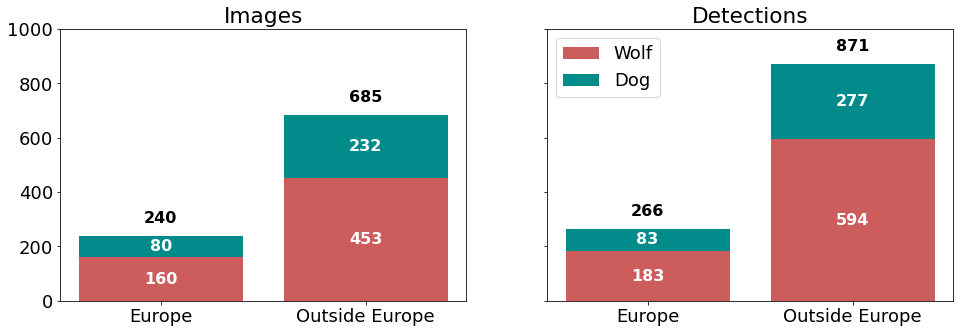

In [9]:
plt.rcParams.update({'font.size': 18})

fig, ax = plt.subplots(1,2, figsize=(16,5), sharey='row')

p1 = ax[0].bar(df_group.index, df_group['wolf'], label='Wolf', color='indianred')
p2 = ax[0].bar(df_group.index, df_group['dog'], bottom =df_group['wolf'],label='Dog', color='darkcyan')

ax[0].set_title('Images')
ax[0].bar_label(p1, label_type='center', fontsize=16, color='white', fontweight='bold')
ax[0].bar_label(p2, label_type='center', fontsize=16, color='white', fontweight='bold')
ax[0].bar_label(p2, padding = 10, fontsize=16, fontweight='bold')

p1 = ax[1].bar(df_group.index, df_group['wolf_d'], label='Wolf', color='indianred')
p2 = ax[1].bar(df_group.index, df_group['dog_d'], bottom =df_group['wolf_d'],label='Dog', color='darkcyan')

ax[1].set_title('Detections')
ax[1].bar_label(p1, label_type='center', fontsize=16, color='white', fontweight='bold')
ax[1].bar_label(p2, label_type='center', fontsize=16, color='white', fontweight='bold')
ax[1].bar_label(p2, padding = 10, fontsize=16, fontweight='bold')

ax[1].legend()
ax[1].set_ylim([0, 1000])

plt.savefig('img_data.png', bbox_inches='tight', dpi=600)
plt.show()

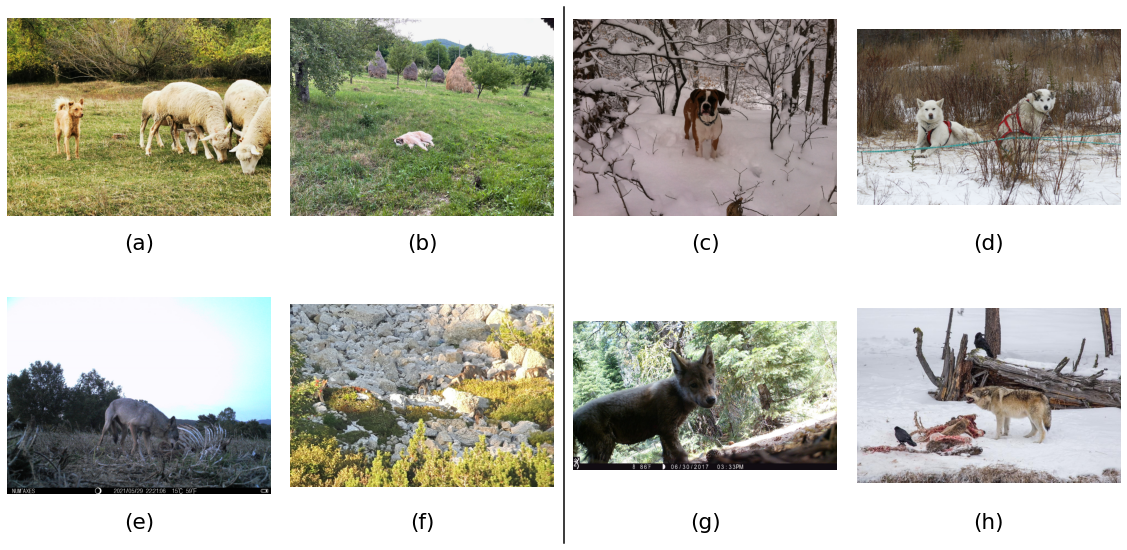

In [10]:
fig, ax = plt.subplots(4,4, figsize=(16,8), gridspec_kw={'height_ratios': [10,0.01, 10, 0.01]})
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']
for region, r, r_i in zip(['europe', 'world'], ['Europe', 'Outside Europe'], range(2)):
    for animal, a, a_i in zip(['dog', 'wolf'], ['Dog', 'Wolf'], range(2)):
        images = os.listdir('images/'+region+'_'+animal+'/')
        img = cv2.imread('images/'+region+'_'+animal+'/'+images[0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[(a_i*2)][r_i*2].imshow(img)
        ax[(a_i*2)][r_i*2].axis('off')
        
        ax[(a_i*2)+1][r_i*2].axis('off')
        ax[(a_i*2)+1][r_i*2].set_title('('+letters[4*a_i + 2*r_i]+')')
        
        img = cv2.imread('images/'+region+'_'+animal+'/'+images[1])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[(a_i*2)][(r_i*2) + 1].imshow(img)
        ax[(a_i*2)][(r_i*2) + 1].axis('off')
        
        ax[(a_i*2)+1][(r_i*2)+1].axis('off')
        ax[(a_i*2)+1][(r_i*2)+1].set_title('('+letters[4*a_i + 2*r_i +1]+')')

fig.add_artist(lines.Line2D([0.5, 0.5], [0.02, 0.95], color='black'))
plt.tight_layout()

plt.savefig('img_samples.png', bbox_inches='tight', dpi=600)
plt.show()